In [121]:
import numpy as np
from scipy.integrate import odeint
import importlib.util
import scipy.stats
import matplotlib.pyplot as plt
import copy
import sys
import os

# Manually specify the path to the directory containing plot_utility.py
util_path = '/home/austin/Drone_AFRL/util'

# Add the directory to the Python path
sys.path.append(util_path)

# import the function we want from that file
from plot_utility import plot_tme

# Define the file path
file_path = '/home/austin/Drone_AFRL/MPC_DRONE.py'
file_path_ekf = '/home/austin/Drone_AFRL/ekf.py'

# Define the module name
module_name = 'MPC_DRONE'
EKF_Module = 'ekf'

# Load the module
spec = importlib.util.spec_from_file_location(module_name, file_path)
MPCD = importlib.util.module_from_spec(spec)
sys.modules[module_name] = MPCD
spec.loader.exec_module(MPCD)

# Load the EKF module
spec_ekf = importlib.util.spec_from_file_location(EKF_Module, file_path_ekf)
EKF = importlib.util.module_from_spec(spec_ekf)
sys.modules[EKF_Module] = EKF
spec_ekf.loader.exec_module(EKF)

Hello from MPC_DRONE.py
ekf.py loaded successfully


In [122]:
np.version.version

'1.24.3'

# setting duration of the simulation in seconds

In [165]:
TIME=100
dt=.1
T_length=int(TIME/dt)
t = np.linspace(0,T_length*dt,T_length)


# Setting up params

In [166]:
m  = 5.0 # [kg] mass
l  = 0.4 # [m] length
Ix = 1.0 # [kg*m^2] moment of inertia
Iy = 1.0 # [kg*m^2] moment of inertia
Iz = 1.0 # [kg*m^2] moment of inertia
Jr = 1.0 # [kg*m^2] polar moment of inertia
b  = 1.0 # thrust coefficient
d  = 1.0 # drag coefficient
Dl = 2.0 # drag coefficient from ground speed
Dr = 2.0 # drag coefficient from rotation speed
params = [m,l,Ix,Iy,Iz,Jr,b,d,Dl,Dr]
g  = 9.81 # m/s^2

# Setting up desired Trajectory

In [167]:
vx  =  np.full (T_length,1)
vy  =  5*np.cos(t/2)
vz  =  np.full (T_length,0)
psi = np.arctan2(vx,vy)

# Use MPC to get U

In [168]:
mpc = MPCD.MpcDrone(vx=vx,vy=vy,vz=vz,psi=psi,params=params,dt=dt, n_horizon=10, r_weight=1)
X_MPC,U_MPC = mpc.get_X_and_U()

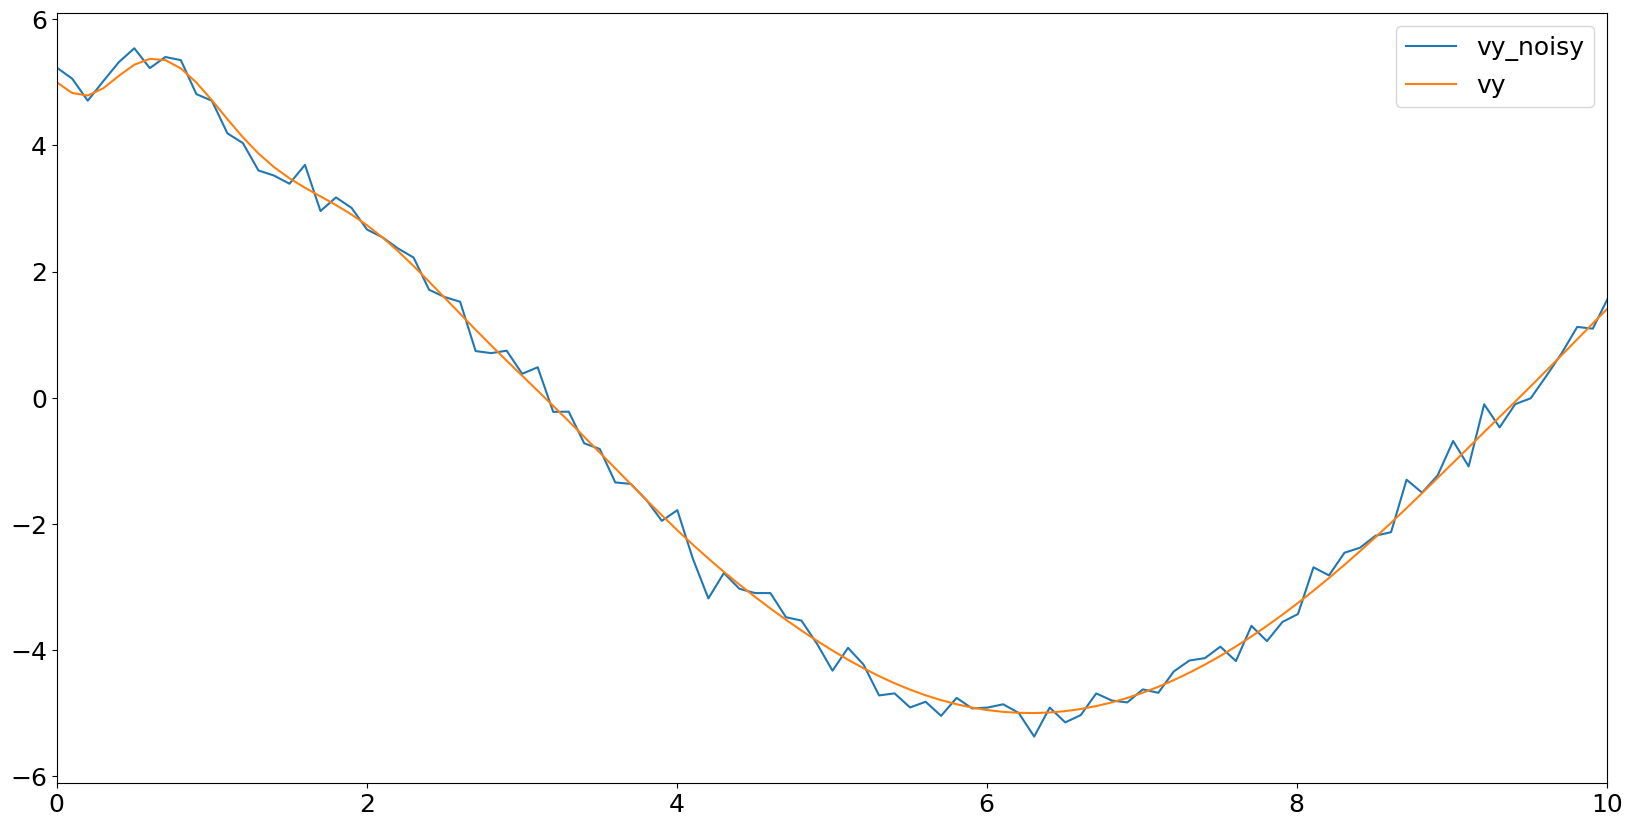

In [176]:
# Noise for measurements:
v=[.2,    # x
   .2,    # vx
   .2,    # y
   .2,    # vy
   .2,    # z
   .2,    # vz
   0.01,  # phi
   0.001, # dphi
   0.01,  # theta
   0.001, # dtheta
   0.01,  # psi
   0.001 # dpsi
   ]
v=np.multiply(v,1)
# print('v:',v)
# add noise to X_MPC
X_MPC_noisy = copy.deepcopy(X_MPC).T
# print('X_MPC_noisy:',X_MPC_noisy[0,:])
for i in range(12):
    X_MPC_noisy[i] = X_MPC_noisy[i] + np.random.normal(0,v[i],T_length)

# print('X_MPC_noisy:',X_MPC_noisy[0])
U=U_MPC.T
# print('X_MPC_noisy:',X_MPC_noisy.shape)
# print('U_MPC:',U_MPC.shape)
plt.figure(figsize=(20,10))
plt.plot(t,X_MPC_noisy[3],label='vy_noisy')
plt.plot(t,X_MPC.T[3],label='vy')
# plt.xlim([0,50])
plt.xlim([0,10])
plt.legend()

# Extended Kalman Filter

Note: this EKF function expects everything to be given as 2D arrays.

In [177]:
# import ekf

In [178]:
def f_d(X, U):
    # Extract state variables
    x, vx, y, vy, z, vz, phi, dphi, theta, dtheta, psi, dpsi = np.ravel(X)
    
    # Extract control inputs
    u1, u2, u3, u4 = np.ravel(U)
    
    # Compute intermediate variables
    U1 = b * (u1**2 + u2**2 + u3**2 + u4**2)
    U2 = b * (u4**2 + u1**2 - u2**2 - u3**2)
    U3 = b * (u3**2 + u4**2 - u1**2 - u2**2)
    U4 = d * (-u1**2 + u2**2 - u3**2 + u4**2)
    Omega = u2 + u4 - u1 - u3
    
    new_x=x + vx * dt
    new_vx = (1/m) * (np.cos(phi) * np.sin(theta) * np.cos(psi) + np.sin(phi) * np.sin(psi)) * U1 - (Dl * vx / m) * dt
    new_y = y + vy * dt
    new_vy = (1/m) * (np.cos(phi) * np.sin(theta) * np.sin(psi) - np.sin(phi) * np.cos(psi)) * U1 - (Dl * vy / m) * dt
    new_z = z + vz * dt
    new_vz = (1/m) * (np.cos(phi) * np.cos(theta)) * U1 - g - (Dl * vz / m) * dt
    new_phi = phi + dphi * dt
    new_dphi = dtheta * dpsi * (Iy - Iz) / Ix - (Jr * dtheta * Omega / Ix) + (U2 * l / Ix) - (Dr * dphi / Ix) * dt
    new_theta = theta + dtheta * dt
    new_dtheta = dphi * dpsi * (Iz - Ix) / Iy + (Jr * dphi * Omega / Iy) + (U3 * l / Iy) - (Dr * dtheta / Iy) * dt
    new_psi = psi + dpsi * dt
    new_dpsi = dphi * dtheta * (Ix - Iy) / Iz + (U4 / Iz) - (Dr * dpsi / Iz) * dt
    
    new_X = np.atleast_2d(np.array([new_x, new_vx, new_y, new_vy, new_z, new_vz, new_phi, new_dphi, new_theta, new_dtheta, new_psi, new_dpsi])).T

    return new_X

# write function as a continuous time function
def f_c(X, U):
    # Extract state variables
    x, vx, y, vy, z, vz, phi, dphi, theta, dtheta, psi, dpsi = np.ravel(X)
    
    # Extract control inputs
    u1, u2, u3, u4 = np.ravel(U)
    
    # Compute intermediate variables
    U1 = b * (u1**2 + u2**2 + u3**2 + u4**2)
    U2 = b * (u4**2 + u1**2 - u2**2 - u3**2)
    U3 = b * (u3**2 + u4**2 - u1**2 - u2**2)
    U4 = d * (-u1**2 + u2**2 - u3**2 + u4**2)
    Omega = u2 + u4 - u1 - u3
    
    dxdt=vx
    dvxdt = (1/m) * (np.cos(phi) * np.sin(theta) * np.cos(psi) + np.sin(phi) * np.sin(psi)) * U1 - (Dl * vx / m)
    dydt=vy
    dvydt = (1/m) * (np.cos(phi) * np.sin(theta) * np.sin(psi) - np.sin(phi) * np.cos(psi)) * U1 - (Dl * vy / m)
    dzdt=vz
    dvzdt = (1/m) * (np.cos(phi) * np.cos(theta)) * U1 - g - (Dl * vz / m)
    dphidt=dphi
    ddphidt = dtheta * dpsi * (Iy - Iz) / Ix - (Jr * dtheta * Omega / Ix) + (U2 * l / Ix) - (Dr * dphi / Ix)
    dthetadt= dtheta
    ddthetadt = dphi * dpsi * (Iz - Ix) / Iy + (Jr * dphi * Omega / Iy) + (U3 * l / Iy) - (Dr * dtheta / Iy)
    dpsidt= dpsi
    ddpsidt = dphi * dtheta * (Ix - Iy) / Iz + (U4 / Iz) - (Dr * dpsi / Iz)

    new_X= scipy.integrate.odeint(lambda X, t: [dxdt, dvxdt, dydt, dvydt, dzdt, dvzdt, dphidt, ddphidt, dthetadt, ddthetadt, dpsidt, ddpsidt], np.ravel(X), [0, dt])[-1]
    new_X = np.atleast_2d(new_X).T
    return new_X

def h_d(X,U):
    # Extract the measured states
    x, vx, y, vy, z, vz, phi, dphi, theta, dtheta, psi, dpsi = np.ravel(X)
    
    # Only return the measured states
    Y=np.atleast_2d(np.array([x, y, z, phi, theta, psi])).T
    return Y

# Define Ynoisy
Ynoisy = copy.deepcopy(X_MPC_noisy)
Ynoisy_small = Ynoisy[[0,2,4,6,8,10],:]


# Define the initial state estimate
# x0 = np.atleast_2d(X_MPC_noisy.T[0]).T
x0=np.atleast_2d(np.array([0.0,vx[0],0.0,vy[0],0.0,vz[0],0.0,0.0,0.0,0.0,psi[0],0.0])).T

# Define the process noise covariance matrix
Q = np.diag(np.array([0.0, 0.1, 0.0, 0.1, 0.0, 0.1, 0.0, 0.1, 0.0, 0.1, 0.0, 0.1]))**2

# define the measurement noise covariance matrix
# cut v down to x ,y ,z ,phi ,theta ,psi
v_small = [v[0],v[2],v[4],v[6],v[8],v[10]]
R = np.power(np.diag(v_small),2)
P0 = np.diag(np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]))**2


# check that all inputs are a two-dimensional array

* Y (number of measuerment states, length of time series)
* X0 (number of states, 1)
* U (number of inputs, length of time series)
* Q (number of states, number of states)
* R (number of measuerment states, number of measuerment states)

In [179]:
# check that all inputs are a two-dimensional array
print("X_MPC_noisy:",X_MPC_noisy.shape) 
print('Ynoisy_small:',Ynoisy_small.shape)
print('x0:',x0.shape)
print('U:',U.shape)
print('Q:',Q.shape)
print('R:',R.shape)
print('P0:',P0.shape)
print('v_small:',v_small)


X_MPC_noisy: (12, 1000)
Ynoisy_small: (6, 1000)
x0: (12, 1)
U: (4, 1000)
Q: (12, 12)
R: (6, 6)
P0: (12, 12)
v_small: [0.2, 0.2, 0.2, 0.01, 0.01, 0.01]


In [180]:
xhat, P, s = EKF.ekf(Ynoisy_small, x0, f_c, h_d, Q, R, U, P0)

In [181]:
x_hat=xhat[0,:] # x estimate
vx_hat=xhat[1,:] # vx estimate
y_hat=xhat[2,:] # y estimate
vy_hat=xhat[3,:] # vy estimate
z_hat=xhat[4,:] # z estimate
vz_hat=xhat[5,:] # vz estimate
phi_hat=xhat[6,:] # phi estimate
dphi_hat=xhat[7,:] # dphi estimate
theta_hat=xhat[8,:] # theta estimate
dtheta_hat=xhat[9,:] # dtheta estimate
psi_hat=xhat[10,:] # psi estimate
dpsi_hat=xhat[11,:] # dpsi estimate


# plotting truth, measuerment, and estimation

(0.0, 50.0)

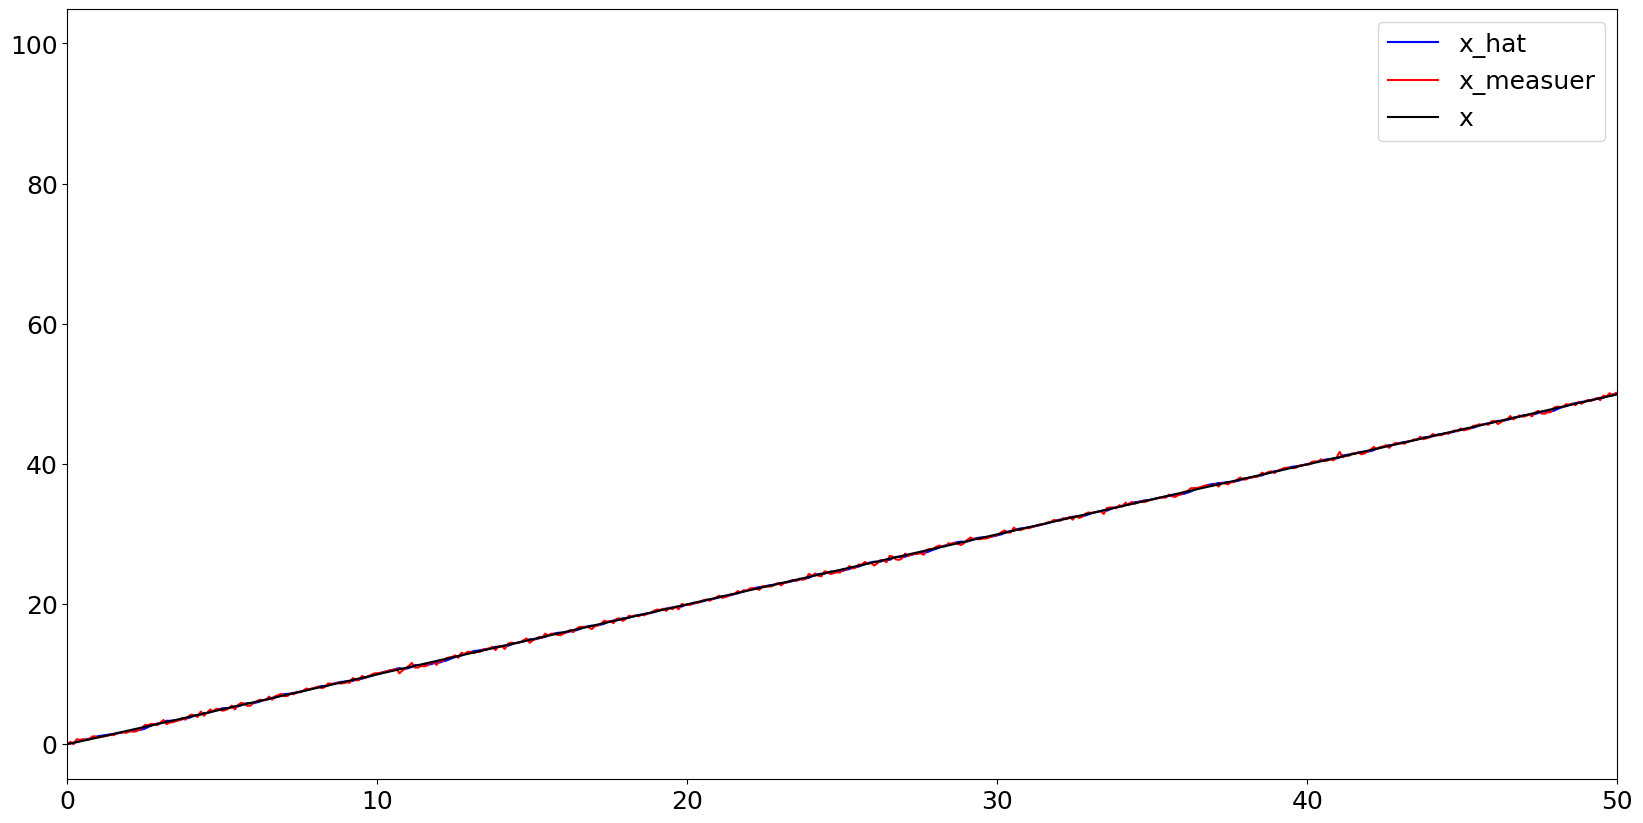

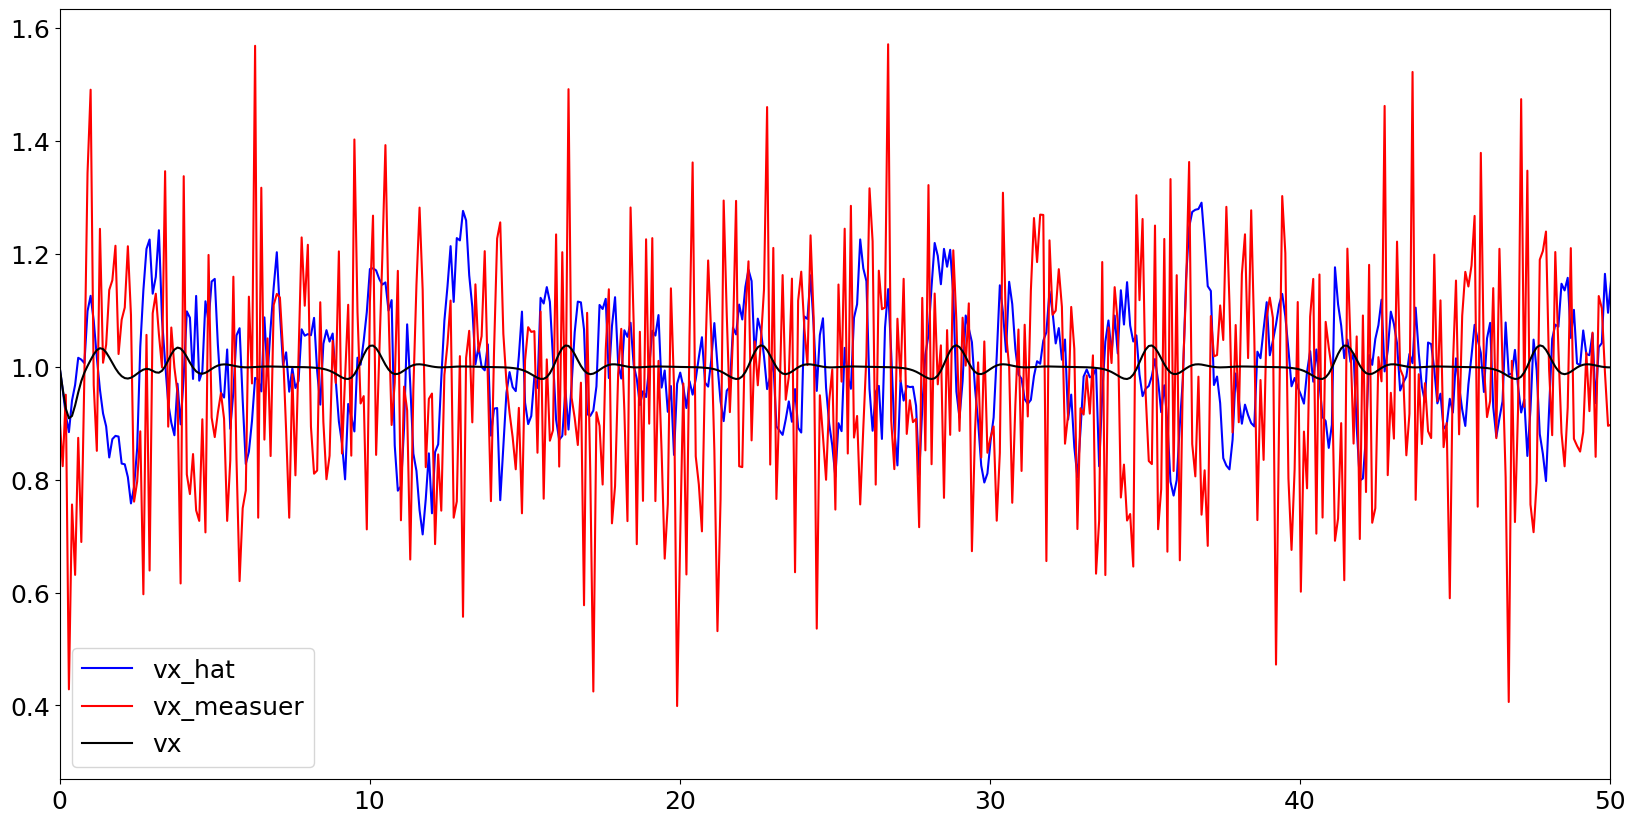

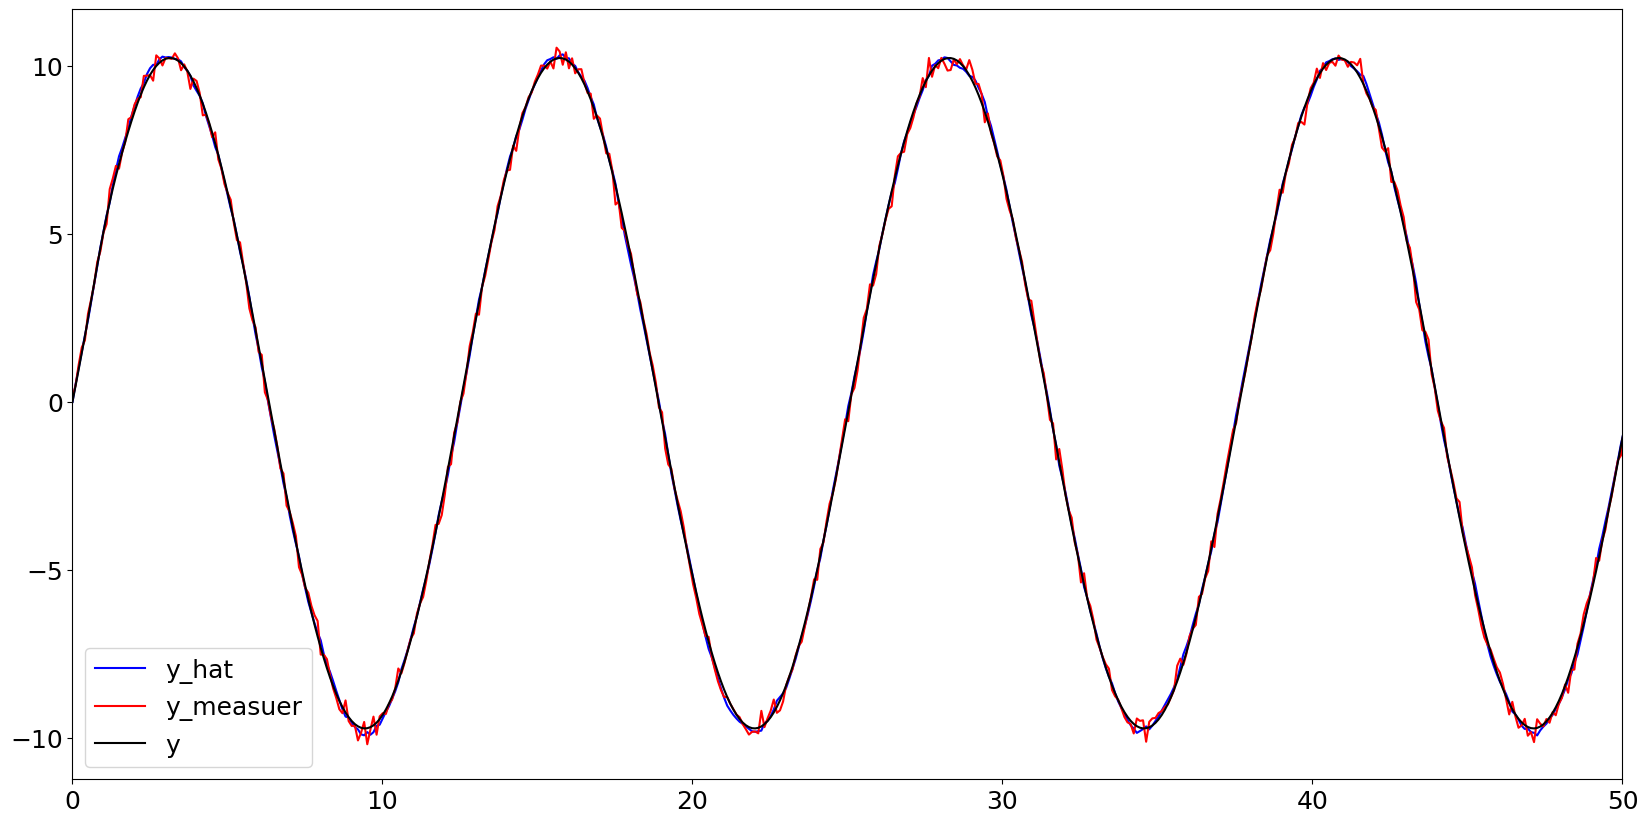

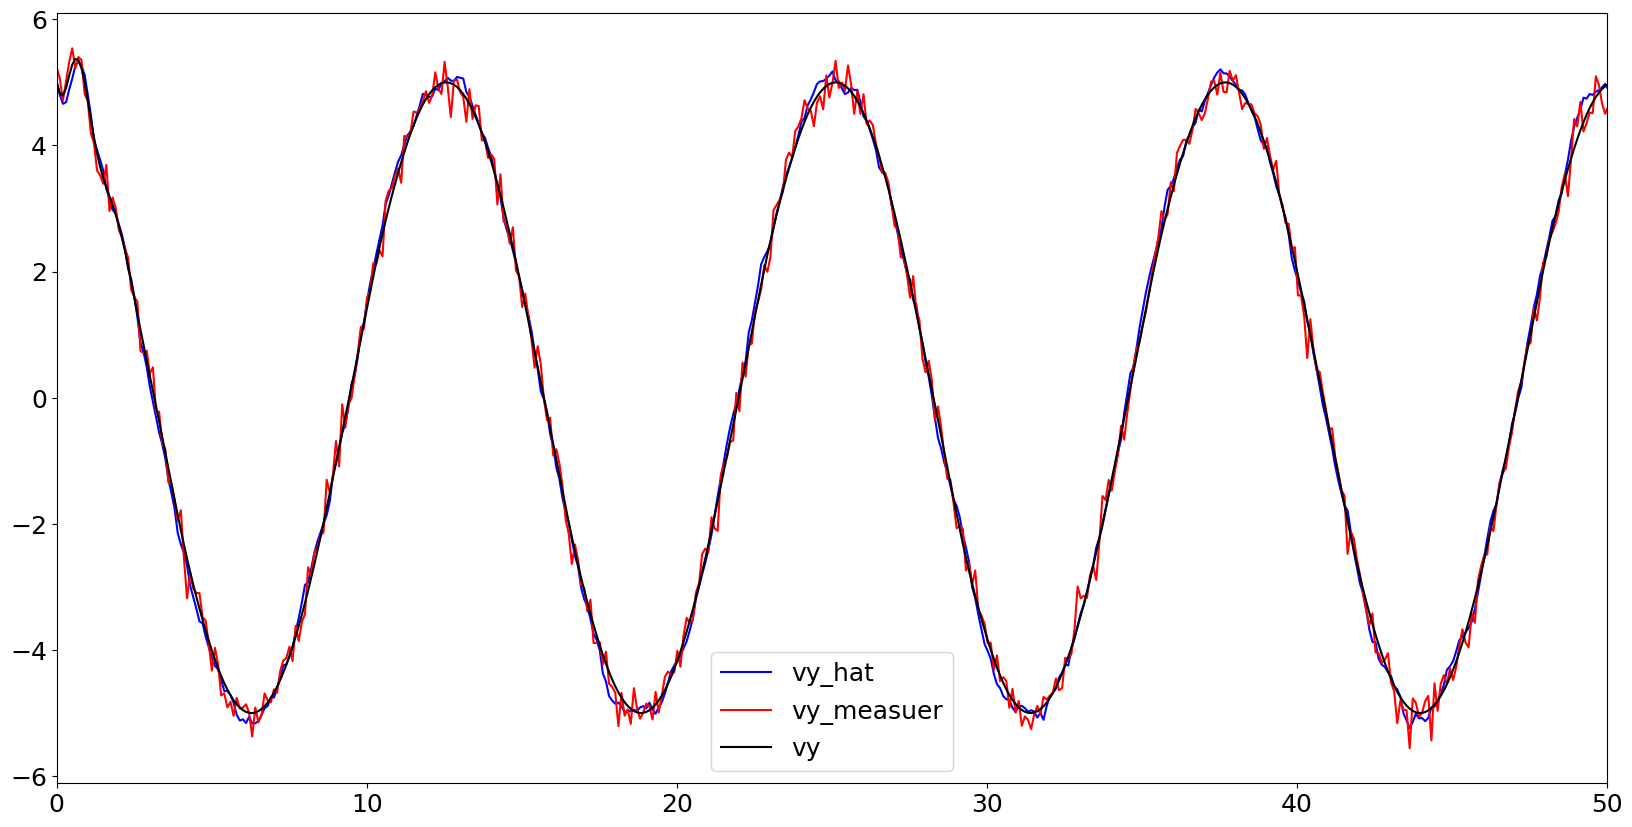

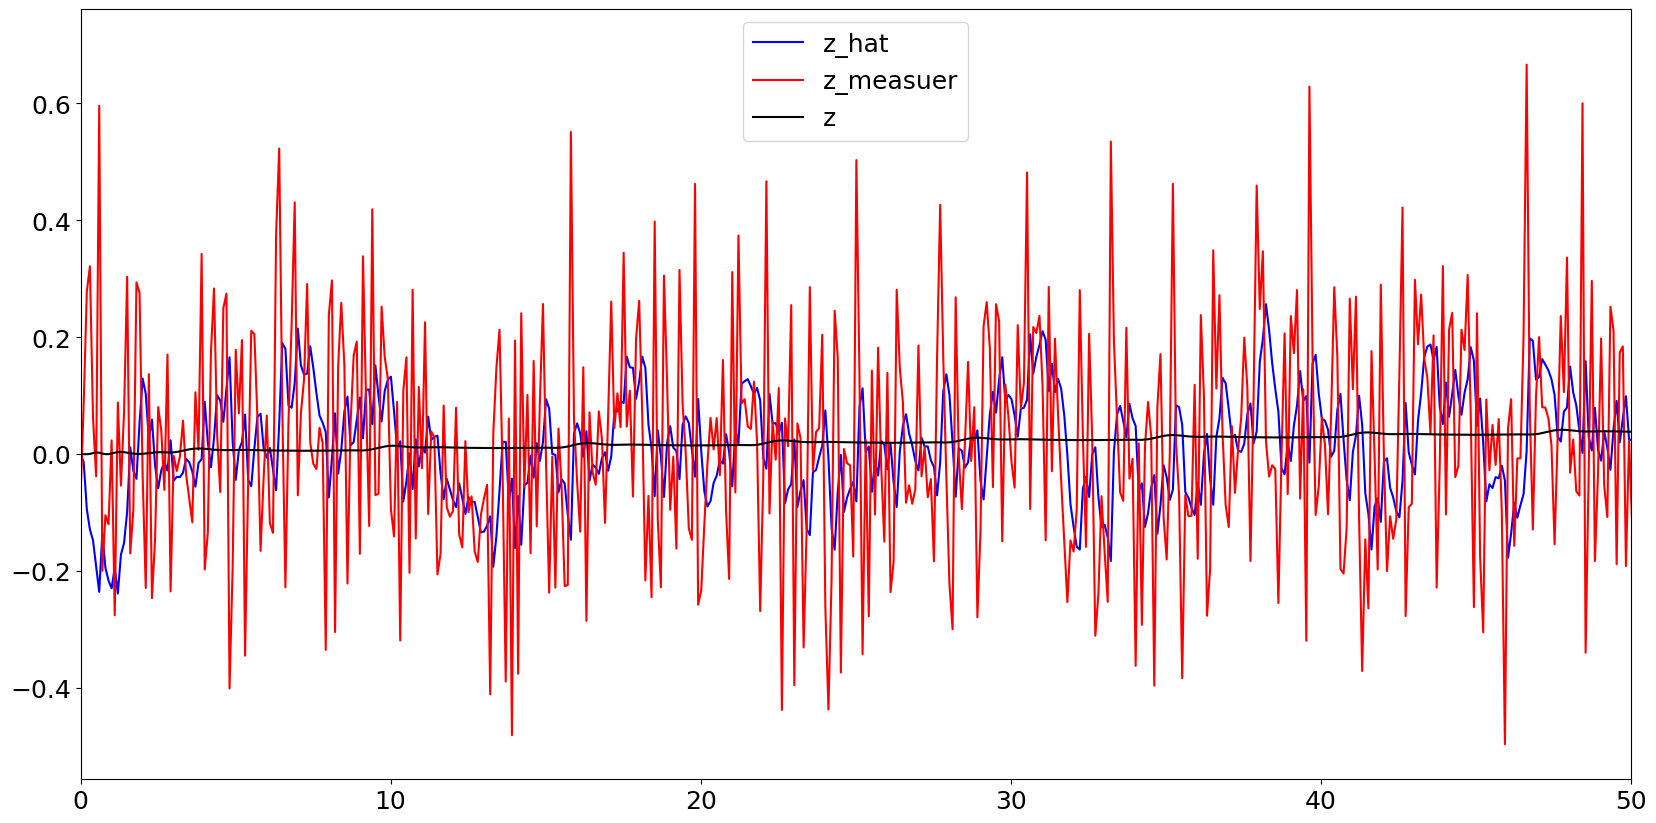

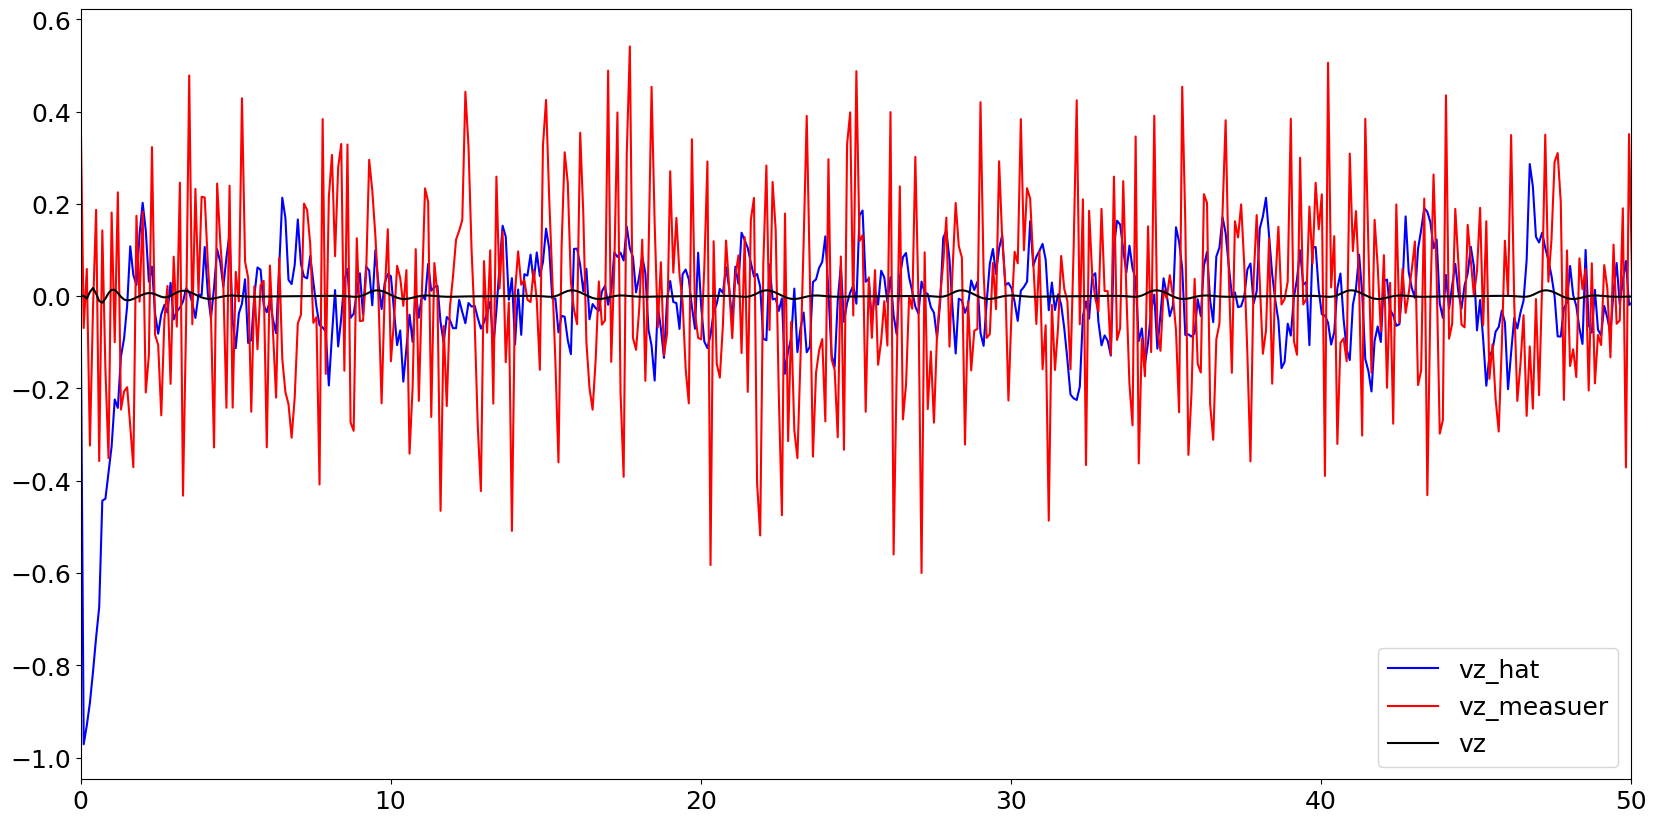

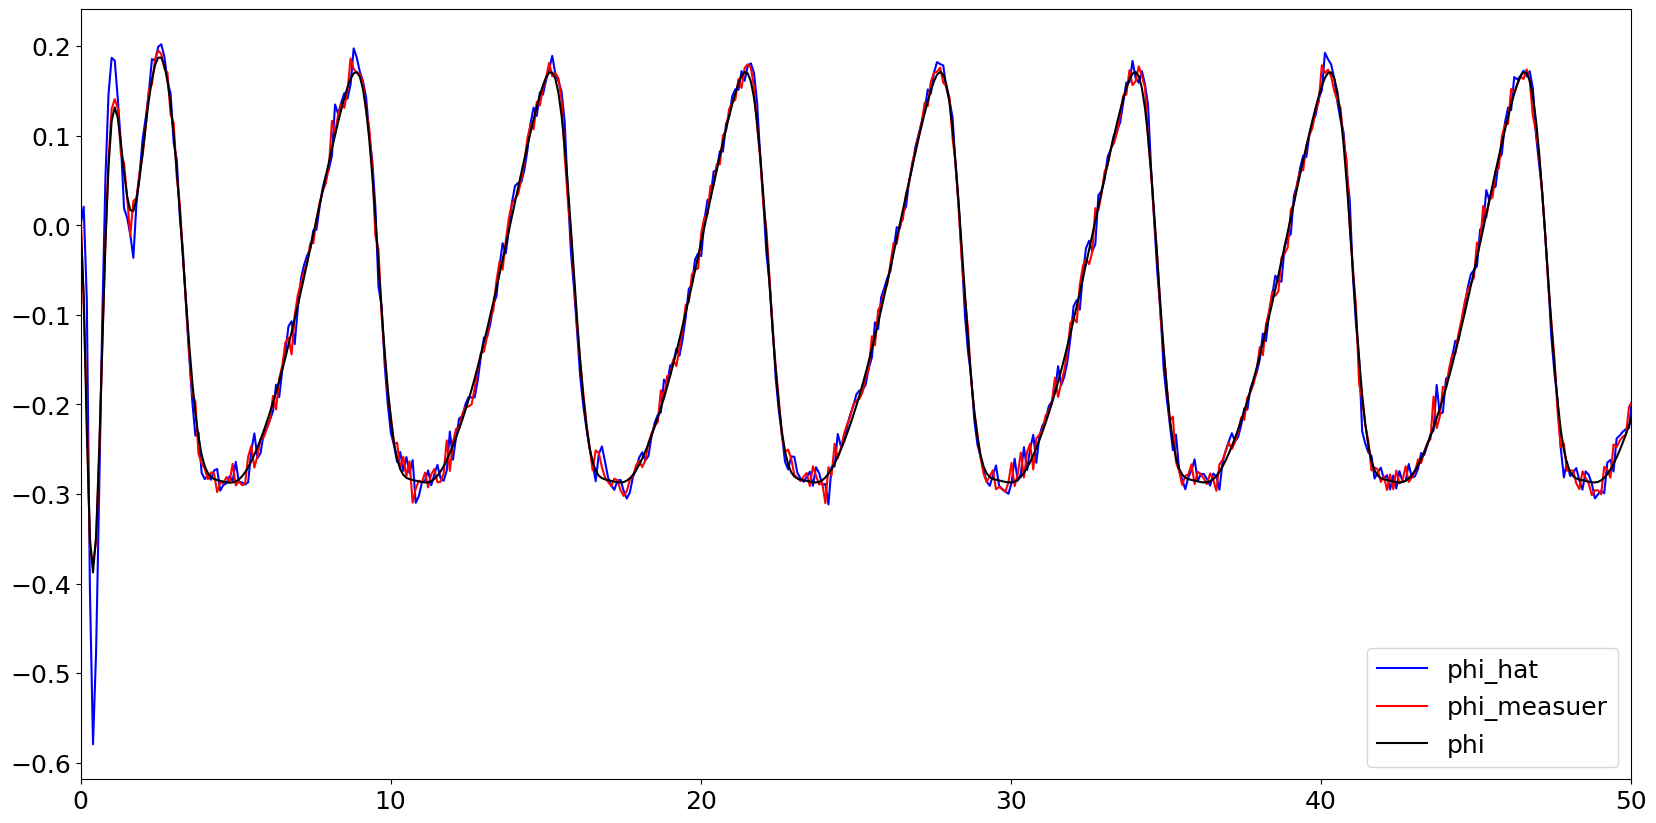

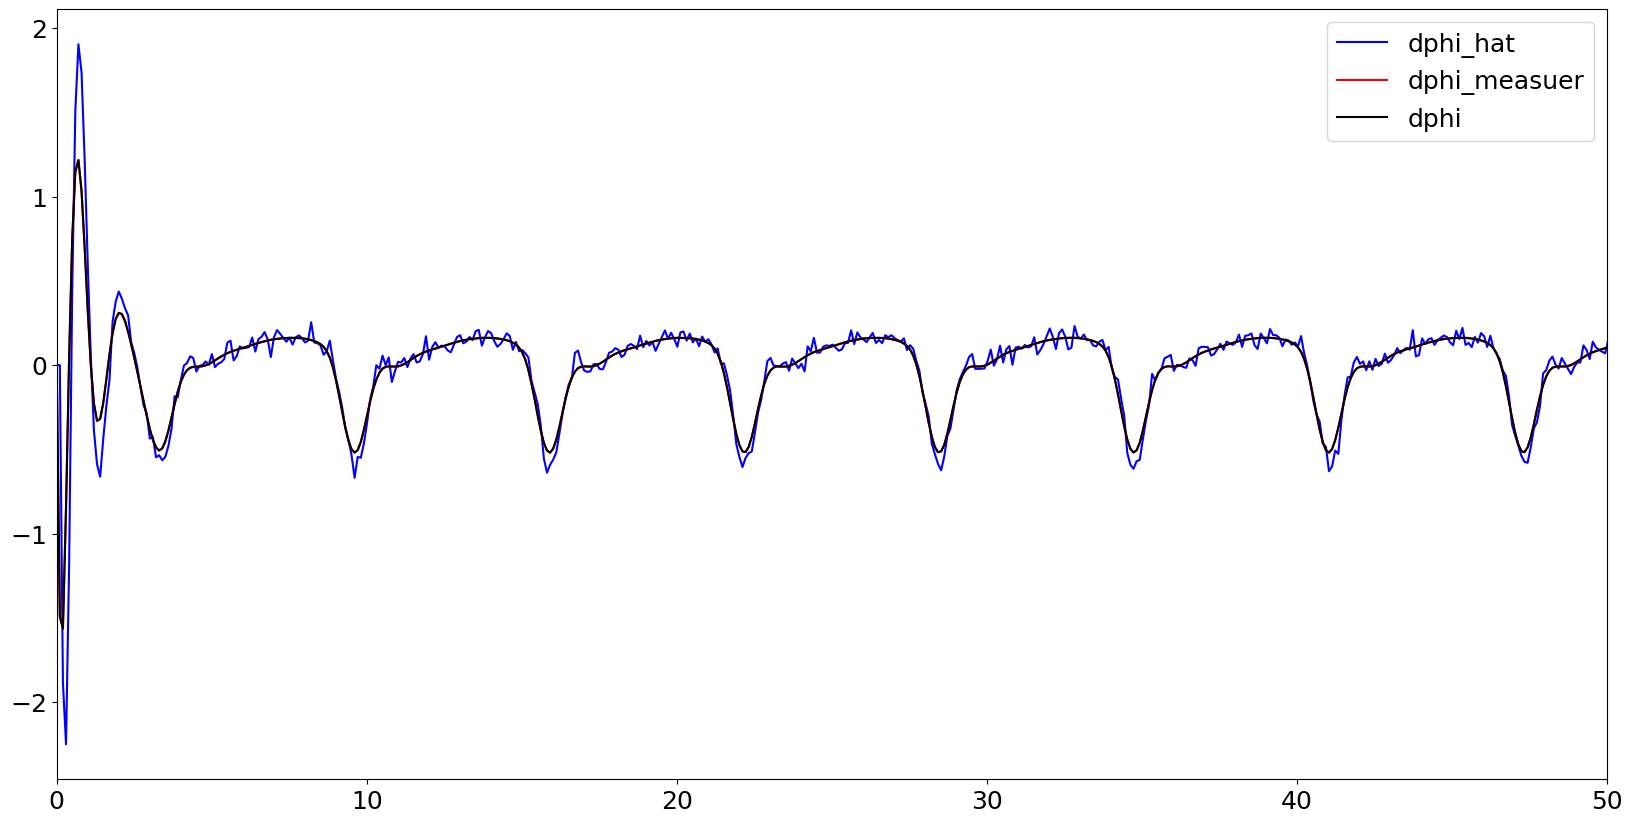

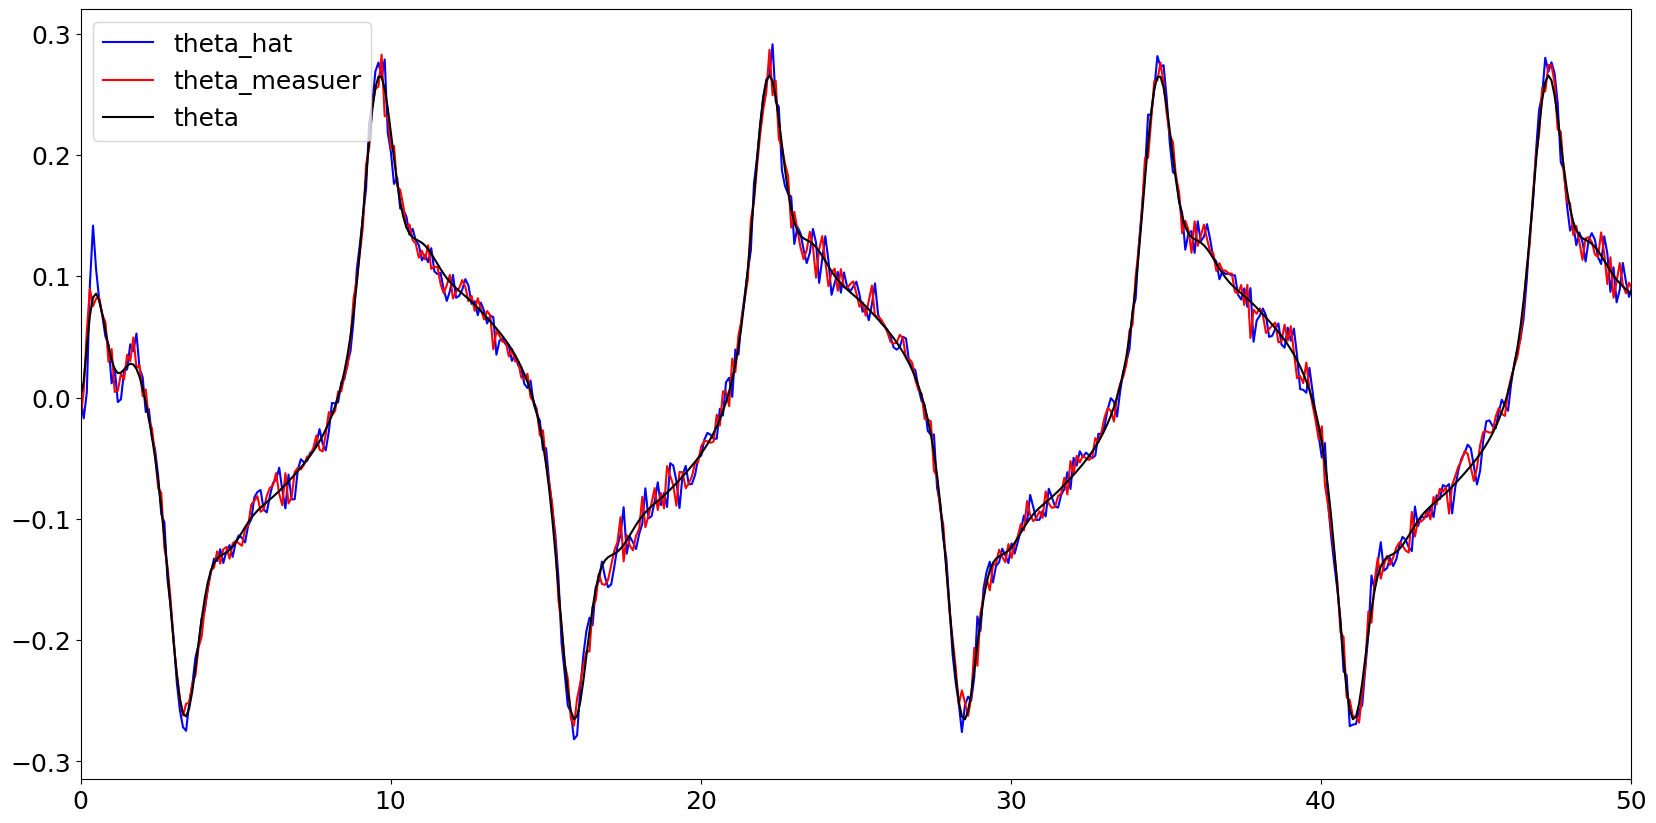

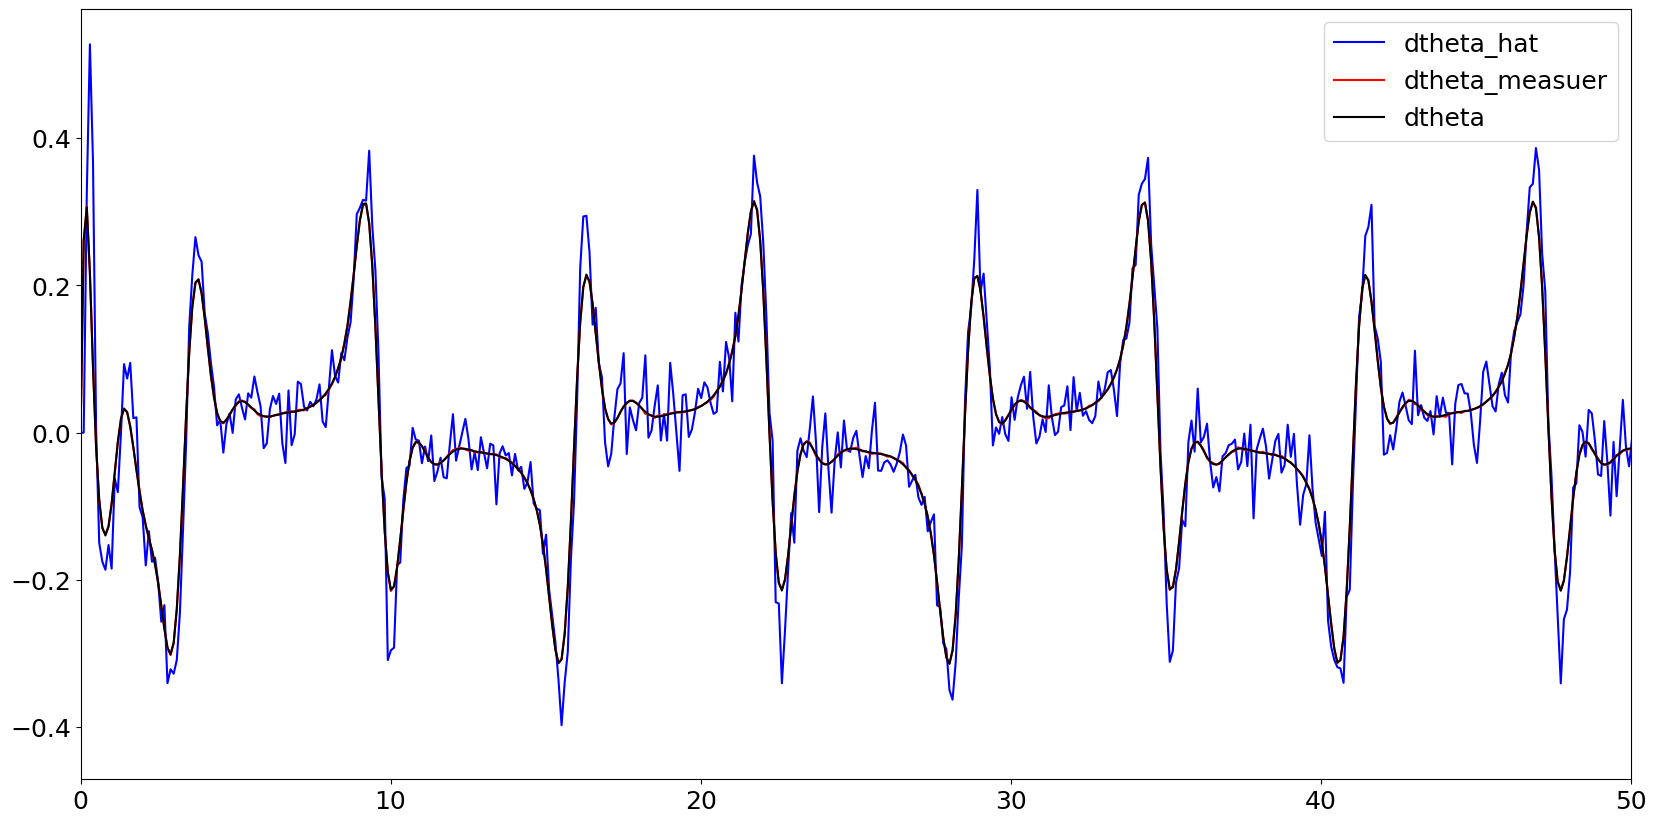

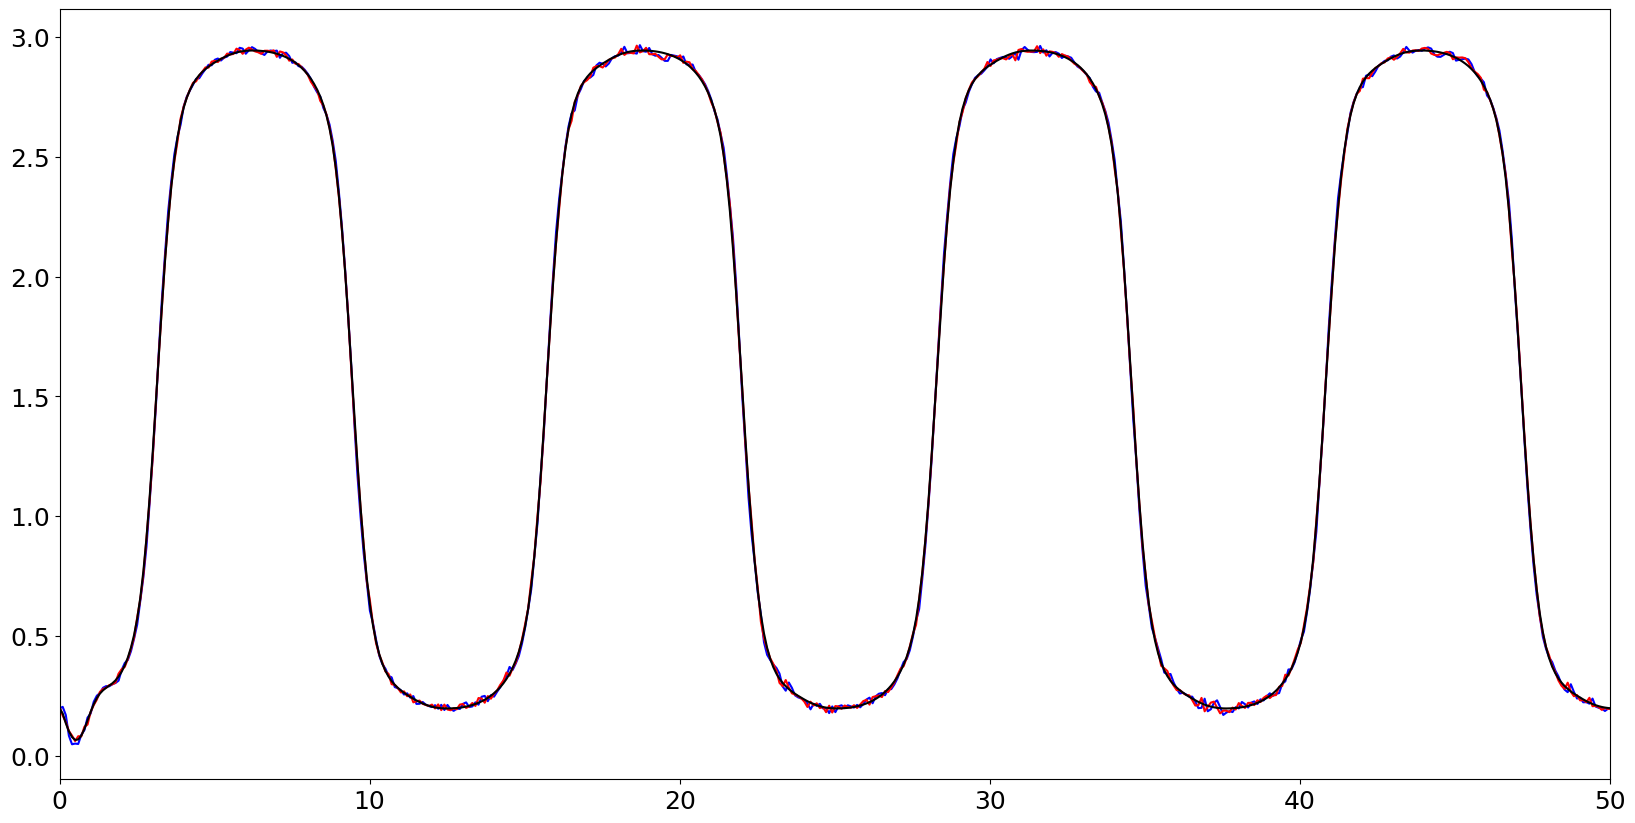

In [182]:
plt.figure(figsize=(20,10))
plt.plot(t,x_hat,label='x_hat',color='blue')
plt.plot(t,X_MPC_noisy[0],label='x_measuer',color='red')
plt.plot(t,X_MPC.T[0],label='x',color='black',alpha=1)
plt.xlim([0,50])
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(t,vx_hat,label='vx_hat',color='blue')
plt.plot(t,X_MPC_noisy[1],label='vx_measuer',color='red')
plt.plot(t,X_MPC.T[1],label='vx',color='black',alpha=1)
plt.xlim([0,50])
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(t,y_hat,label='y_hat',color='blue')
plt.plot(t,X_MPC_noisy[2],label='y_measuer',color='red')
plt.plot(t,X_MPC.T[2],label='y',color='black',alpha=1)
plt.xlim([0,50])
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(t,vy_hat,label='vy_hat',color='blue')
plt.plot(t,X_MPC_noisy[3],label='vy_measuer',color='red')
plt.plot(t,X_MPC.T[3],label='vy',color='black',alpha=1)
plt.xlim([0,50])
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(t,z_hat,label='z_hat',color='blue')
plt.plot(t,X_MPC_noisy[4],label='z_measuer',color='red')
plt.plot(t,X_MPC.T[4],label='z',color='black',alpha=1)
plt.xlim([0,50])
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(t,vz_hat,label='vz_hat',color='blue')
plt.plot(t,X_MPC_noisy[5],label='vz_measuer',color='red')
plt.plot(t,X_MPC.T[5],label='vz',color='black',alpha=1)
plt.xlim([0,50])
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(t,phi_hat,label='phi_hat',color='blue')
plt.plot(t,X_MPC_noisy[6],label='phi_measuer',color='red')
plt.plot(t,X_MPC.T[6],label='phi',color='black',alpha=1)
plt.xlim([0,50])
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(t,dphi_hat,label='dphi_hat',color='blue')
plt.plot(t,X_MPC_noisy[7],label='dphi_measuer',color='red')
plt.plot(t,X_MPC.T[7],label='dphi',color='black',alpha=1)
plt.xlim([0,50])
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(t,theta_hat,label='theta_hat',color='blue')
plt.plot(t,X_MPC_noisy[8],label='theta_measuer',color='red')
plt.plot(t,X_MPC.T[8],label='theta',color='black',alpha=1)
plt.xlim([0,50])
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(t,dtheta_hat,label='dtheta_hat',color='blue')
plt.plot(t,X_MPC_noisy[9],label='dtheta_measuer',color='red')
plt.plot(t,X_MPC.T[9],label='dtheta',color='black',alpha=1)
plt.xlim([0,50])
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(t,psi_hat,label='psi_hat',color='blue')
plt.plot(t,X_MPC_noisy[10],label='psi_measuer',color='red')
plt.plot(t,X_MPC.T[10],label='psi',color='black',alpha=1)
plt.xlim([0,50])
